# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. This code is already included in 'tensorflow_vgg' directory, sdo you don't have to clone it.

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. **You'll need to clone the repo into the folder containing this notebook.** Then download the parameter file using the next cell.

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

class DLProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.block_size) * block_size)
        self.last_block = block_num

vgg_dir = 'tensorflow_vgg/'
        
if not isfile(vgg_dir + 'vgg16.py'):
    with DLProgress(unit='B', unit_scale=True, miniters=1) as pbar:
        urlretrieve('https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
                   vgg_dir + 'vgg16.py',
                   pbar.hook)
else:
    print("file exists")

file exists


## Flower power

Here we'll be using VGGNet to classify images of flowers. To get the flower dataset, run the cell below. This dataset comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining).

In [2]:
import tarfile

class DLProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num-self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1) as pbar:
        urlretrieve('http://download.tensorflow.org/example_images/flower_photos.tgz',
                   'flower_photos.tar.gz',
                   pbar.hook)

if not isdir('flower_photos'):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()


## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

Here we're using the `vgg16` module from `tensorflow_vgg`. The network takes images of size $224 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py)):

```
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
```

So what we want are the values of the first fully connected layer, after being ReLUd (`self.relu6`). To build the network, we use

```
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
```

This creates the `vgg` object, then builds the graph with `vgg.build(input_)`. Then to get the values from the layer,

```
feed_dict = {input_: images}
codes = sess.run(vgg.relu6, feed_dict=feed_dict)
```

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [4]:
# data_dir = 'flower_photos/'
# contents = os.listdir(data_dir)
# classes = [each for each in contents if os.path.isdir(data_dir + each)]
# classes

In [5]:
data_dir = 'flower_photos/'
content = os.listdir(data_dir)
classes = [clas for clas in content if isdir(data_dir + clas)]
classes


['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']

Below I'm running images through the VGG network in batches.

> **Exercise:** Below, build the VGG network. Also get the codes from the first fully connected layer (make sure you get the ReLUd values).

In [6]:
import tensorflow as tf
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [7]:
tot_images = 0
for d in content:
    img_path = data_dir+d
    if isdir(img_path):
        tot_images += len(os.listdir(img_path))
tot_images

3670

In [8]:
# [file for file in os.listdir(img_path) if isdir(img_path)]

In [10]:
vgg = vgg16.Vgg16()
input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])

batch = []
labels = []
codes_list = []
codes = None

batch_size = 10

with tf.Session() as sess:
    with tf.name_scope("content_vgg"):
        vgg.build(input_)    
        
    for clas in classes:
        print('Starting {} images:'.format(clas))
        img_path = data_dir + clas
        #delete the license before rnning this
        files = [file for file in os.listdir(img_path) if isdir(img_path)]
        
        for ii, file in enumerate(files, 1):
            img = utils.load_image(img_path + '/' +file)
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(clas)
            
            if ii % batch_size == 0 or ii == len(files):
                images = np.concatenate(batch)
                
                codes_batch = sess.run(vgg.relu6, feed_dict={input_:images})
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                    
                batch = []
        print('{} images processed'.format(clas))
    

/Users/romaahuja/Courses/DeepLearning/Dev/deep-learning/transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 7s
Starting roses images:


/Applications/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Applications/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


roses images processed
Starting sunflowers images:
sunflowers images processed
Starting daisy images:
daisy images processed
Starting dandelion images:
dandelion images processed
Starting tulips images:
tulips images processed


In [11]:
with open('codes', 'w' ) as f:
    codes.tofile(f)
    
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [1]:
# read codes and labels from file
import csv
import numpy as np

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

In [2]:
np.unique(labels)

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

> **Exercise:** From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [3]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

label_vecs = lb.transform(labels)


In [4]:
label_vecs[0]

array([0, 0, 1, 0, 0])

In [5]:
len(codes), len(labels),len(label_vecs)

(3670, 3670, 3670)

Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices. Be sure to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) and the [user guide](http://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split).

> **Exercise:** Use StratifiedShuffleSplit to split the codes and labels into training, validation, and test sets.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
splitter = ss.split(codes, label_vecs)

train_idx, val_idx = next(splitter)

half = int(len(val_idx)/2)

# half

val_idx, test_idx = val_idx[:half], val_idx[half:]

train_x, train_y = codes[train_idx], label_vecs[train_idx]
val_x, val_y = codes[val_idx], label_vecs[val_idx]
test_x, test_y = codes[test_idx], label_vecs[test_idx]

In [7]:
len(train_idx), len(val_idx)

(2936, 367)

In [8]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)


If you did it right, you should see these sizes for the training sets:

```
Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)
```

### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [9]:
import tensorflow as tf
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils
import matplotlib.pyplot as plt
from scipy.ndimage import imread

%matplotlib inline

In [10]:
codes.shape, label_vecs.shape

((3670, 4096), (3670, 5))

In [11]:
inputs_ = tf.placeholder(tf.float32, [None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, [None, label_vecs.shape[1]])

fc = tf.contrib.layers.fully_connected(inputs_, 256)

logits = tf.contrib.layers.fully_connected(fc, label_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred= tf.equal(tf.argmax(predicted,1),tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [12]:
def get_batches(x, y, n_batches=10):
    batch_size = len(x)//n_batches
    
    curr = 0
    for i in range(n_batches):
        if (i == (n_batches-1)):
            X, Y = x[curr:], y[curr:] 
        else:
            X, Y = x[curr:curr+batch_size], y[curr:curr+batch_size] 
            curr = curr+batch_size
        yield X,Y
        

In [13]:
# def get_batches(x, y, n_batches=10):
#     """ Return a generator that yields batches from arrays x and y. """
#     batch_size = len(x)//n_batches
    
#     for ii in range(0, n_batches*batch_size, batch_size):
#         # If we're not on the last batch, grab data with size batch_size
#         if ii != (n_batches-1)*batch_size:
#             X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
#         # On the last batch, grab the rest of the data
#         else:
#             X, Y = x[ii:], y[ii:]
#         # I love generators
#         yield X, Y

In [14]:
for a,b in get_batches([2,2,2,3,3,3,4,4,4],[2,2,2,3,3,3,4,4,4], 3):
    print(a)


[2, 2, 2]
[3, 3, 3]
[4, 4, 4]


### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help. Use the `get_batches` function I wrote before to get your batches like `for x, y in get_batches(train_x, train_y)`. Or write your own!

In [15]:
epochs = 10

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        for x, y in get_batches(train_x, train_y):
#             loss, _ = sess.run([cost, optimizer], feed_dict={inputs_:train_x, labels_:train_y})
            loss, _ = sess.run([cost, optimizer], feed_dict={inputs_:x, labels_:y})
            val_acc = sess.run(accuracy, feed_dict={inputs_:val_x, labels_:val_y})
            print("Epoch: {}/{}".format(i, epochs),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/flowers1.ckpt")

Epoch: 0/10 Validation Acc: 0.5422
Epoch: 0/10 Validation Acc: 0.5668
Epoch: 0/10 Validation Acc: 0.6703
Epoch: 0/10 Validation Acc: 0.7057
Epoch: 0/10 Validation Acc: 0.6621
Epoch: 0/10 Validation Acc: 0.7357
Epoch: 0/10 Validation Acc: 0.7575
Epoch: 0/10 Validation Acc: 0.7466
Epoch: 0/10 Validation Acc: 0.7112
Epoch: 0/10 Validation Acc: 0.7166
Epoch: 1/10 Validation Acc: 0.7602
Epoch: 1/10 Validation Acc: 0.7902
Epoch: 1/10 Validation Acc: 0.8256
Epoch: 1/10 Validation Acc: 0.8474
Epoch: 1/10 Validation Acc: 0.8665
Epoch: 1/10 Validation Acc: 0.8665
Epoch: 1/10 Validation Acc: 0.8610
Epoch: 1/10 Validation Acc: 0.8420
Epoch: 1/10 Validation Acc: 0.8229
Epoch: 1/10 Validation Acc: 0.8283
Epoch: 2/10 Validation Acc: 0.8474
Epoch: 2/10 Validation Acc: 0.8556
Epoch: 2/10 Validation Acc: 0.8474
Epoch: 2/10 Validation Acc: 0.8529
Epoch: 2/10 Validation Acc: 0.8610
Epoch: 2/10 Validation Acc: 0.8692
Epoch: 2/10 Validation Acc: 0.8719
Epoch: 2/10 Validation Acc: 0.8692
Epoch: 2/10 Validati

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [37]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint("checkpoints"))
    test_acc = sess.run(accuracy, feed_dict={inputs_:test_x, labels_:test_y})
    print(test_acc)

INFO:tensorflow:Restoring parameters from checkpoints/flowers1.ckpt
0.89918256


In [17]:
from scipy.ndimage import imread


Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  app.launch_new_instance()


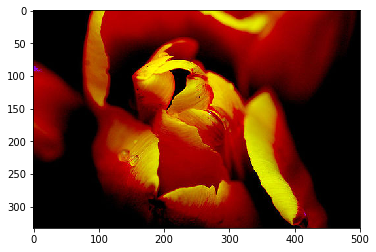

In [64]:
# test_img_path = 'flower_photos/roses/10090824183_d02c613f10_m.jpg'
test_img_path = 'flower_photos/tulips/10791227_7168491604.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [53]:
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16.Vgg16()
    vgg.build(input_)

/Users/romaahuja/Courses/DeepLearning/Dev/deep-learning/transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 6s


In [65]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))
    code = sess.run(vgg.relu6, feed_dict={input_:img})
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    prediction = sess.run(predicted, feed_dict={inputs_:code}).squeeze()

/Applications/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


INFO:tensorflow:Restoring parameters from checkpoints/flowers1.ckpt


In [66]:
# type(lb.classes_)

In [67]:
# lb.classes_[0]

In [68]:
# abc = prediction.round()
# np.where(abc==1)[0][0]


In [69]:
lb.classes_[np.where(prediction.round()==1)[0][0]]

'roses'

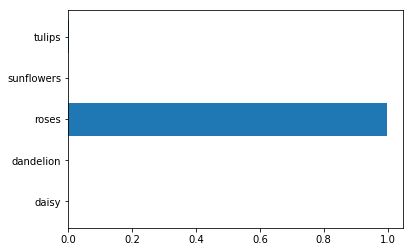

In [70]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)

In [109]:
# fig, ax = plt.subplots(nrows=1, ncols=1)
# plt.subplot(121)
# plt.imshow(imread(test_img_path))
# plt.subplot(122)
# plt.imshow(imread(test_img_path))

In [110]:
test_img_path = 'flower_photos/dandelion/8223949_2928d3f6f6_n.jpg'
test_img = imread(test_img_path)
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))
    code = sess.run(vgg.relu6, feed_dict={input_:img})
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    prediction = sess.run(predicted, feed_dict={inputs_:code}).squeeze()
print('Prdeiction:',lb.classes_[np.where(prediction.round()==1)[0][0]])


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/Applications/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


INFO:tensorflow:Restoring parameters from checkpoints/flowers1.ckpt
Prdeiction: dandelion


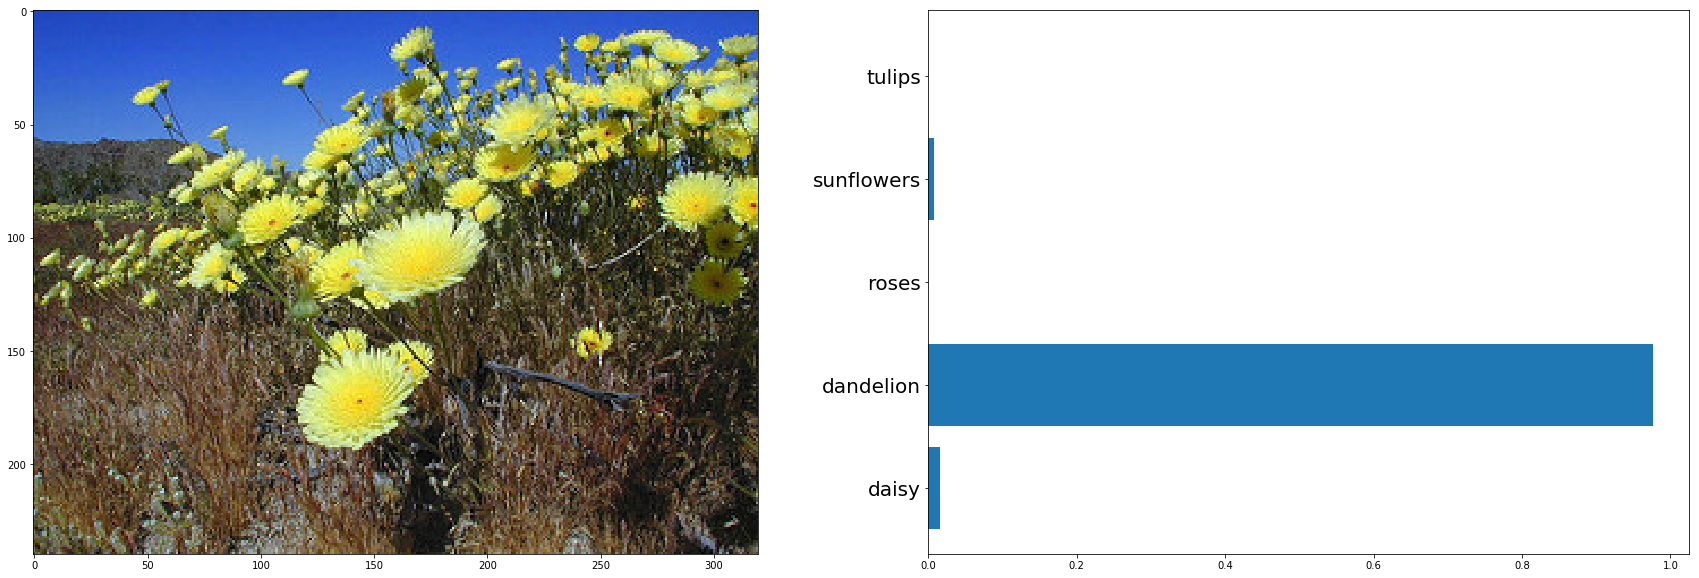

In [111]:
fig = plt.figure(figsize=(30,10))
plt.subplot(121)
plt.imshow(test_img)
plt.subplot(122)
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_,fontsize=20)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/Applications/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


INFO:tensorflow:Restoring parameters from checkpoints/flowers1.ckpt
Prdeiction: sunflowers


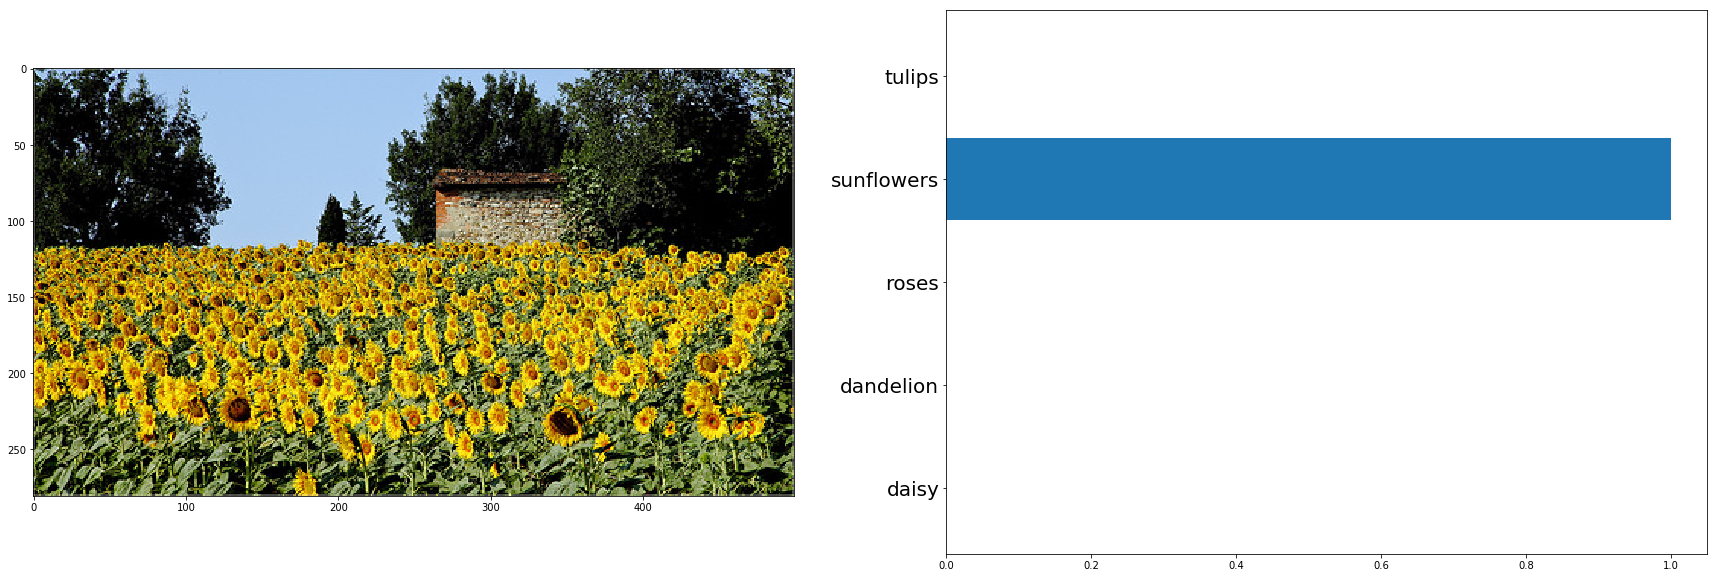

In [112]:
test_img_path = 'flower_photos/sunflowers/19697910486_0086d893a2.jpg'
test_img = imread(test_img_path)
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))
    code = sess.run(vgg.relu6, feed_dict={input_:img})
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    prediction = sess.run(predicted, feed_dict={inputs_:code}).squeeze()
print('Prdeiction:',lb.classes_[np.where(prediction.round()==1)[0][0]])
fig = plt.figure(figsize=(30,10))
plt.subplot(121)
plt.imshow(test_img)
plt.subplot(122)
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_,fontsize=20)